# Imports

In [3]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Create Directorys

In [4]:
BASE_DIR = 'code/data_cropped/'
names = ["broken", "closed_seal_broken", "closed_sealed", "open_broken"]

tf.random.set_seed(1)

# Reorganize the folder structure:

In [5]:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

# Moce the image files

In [6]:
orig_folders = ["broken/", "closed_seal_broken/", "closed_sealed/", "open_broken/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5)
    n_valid = int((number_of_images*0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

FileNotFoundError: [Errno 2] No such file or directory: '/home/leon/Documents/data_cropped/broken/'

# Transfer learning model

In [7]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

2023-01-14 17:21:05.167062: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-14 17:21:05.167077: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-14 17:21:05.167090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Leon-PC): /proc/driver/nvidia/version does not exist
2023-01-14 17:21:05.167616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<class 'keras.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (Ma

# Convert to Sequential model, omit the last layer

In [8]:
model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    model.add(layer)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

# Set trainable=False for all layers, we don't want to train them again

In [10]:
for layer in model.layers:
    layer.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

# Add a last classification layer for our use case with 4 classes

In [11]:
model.add(layers.Dense(4))

# Loss and optimizer

In [12]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

# Get the preprocessing function of this model

In [13]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Generate batches of tensor image data with real-time data augmentation.

In [14]:
train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    '/home/leon/Documents/data_cropped/train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=32,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    '/home/leon/Documents/data_cropped/val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=32,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    '/home/leon/Documents/data_cropped/test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=32,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 797 images belonging to 4 classes.
Found 331 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [15]:
epochs = 20

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=2
)

history = model.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)

Epoch 1/20
25/25 - 85s - loss: 0.6884 - accuracy: 0.7440 - val_loss: 0.2707 - val_accuracy: 0.8973 - 85s/epoch - 3s/step
Epoch 2/20
25/25 - 78s - loss: 0.1765 - accuracy: 0.9448 - val_loss: 0.1703 - val_accuracy: 0.9547 - 78s/epoch - 3s/step
Epoch 3/20
25/25 - 76s - loss: 0.1101 - accuracy: 0.9686 - val_loss: 0.1420 - val_accuracy: 0.9486 - 76s/epoch - 3s/step
Epoch 4/20
25/25 - 85s - loss: 0.0698 - accuracy: 0.9849 - val_loss: 0.1133 - val_accuracy: 0.9698 - 85s/epoch - 3s/step
Epoch 5/20
25/25 - 83s - loss: 0.0546 - accuracy: 0.9862 - val_loss: 0.1023 - val_accuracy: 0.9668 - 83s/epoch - 3s/step
Epoch 6/20
25/25 - 80s - loss: 0.0497 - accuracy: 0.9887 - val_loss: 0.1029 - val_accuracy: 0.9728 - 80s/epoch - 3s/step
Epoch 7/20
25/25 - 80s - loss: 0.0348 - accuracy: 0.9950 - val_loss: 0.0903 - val_accuracy: 0.9728 - 80s/epoch - 3s/step
Epoch 8/20
25/25 - 85s - loss: 0.0264 - accuracy: 0.9987 - val_loss: 0.0858 - val_accuracy: 0.9789 - 85s/epoch - 3s/step
Epoch 9/20
25/25 - 84s - loss: 0

# Save of Model

In [16]:
model.save("BeerBottleTL_modelNew.h5")

# Evaluation

In [17]:
model.evaluate(test_batches, verbose=2)

7/7 - 15s - loss: 0.1017 - accuracy: 0.9600 - 15s/epoch - 2s/step


[0.10168323665857315, 0.9599999785423279]

# Plot of loss and accuracy

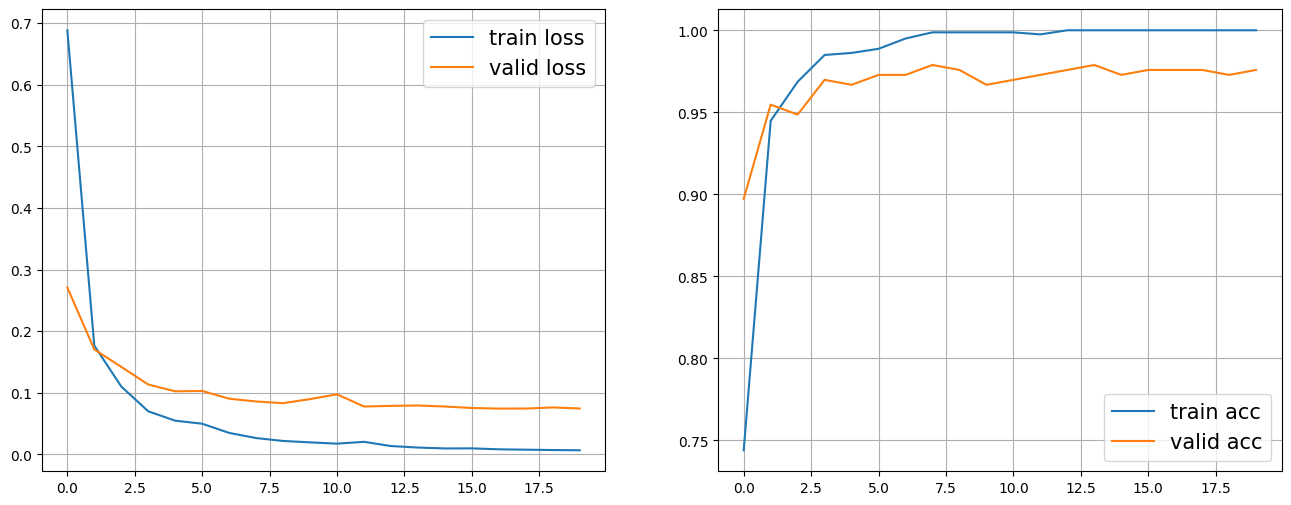

In [18]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15)

# Test evaluation

In [19]:
path_test = '/home/leon/Documents/test_images_cropped'

test_batchsize = 4

test_ds = tf.keras.utils.image_dataset_from_directory(
  path_test,
  seed=123,
  image_size=(224, 224),
  batch_size=test_batchsize
)

results= model.evaluate(test_ds)

print(f"test loss: {results[0]}: test acc: {results[1]*100}%")

Found 4 files belonging to 4 classes.
1/1 [==============================] - 1s 727ms/step - loss: 0.2412 - accuracy: 0.7500
test loss: 0.24119022488594055: test acc: 75.0%


In [20]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`

predictions = model.predict(test_ds)

for i in range(len(predictions)):

  score = tf.nn.softmax(predictions[i])

  print(f"\nPrediction is:{format(names[np.argmax(score)])} with {100 * np.max(score)}% confidence")

1/1 [==============================] - 1s 817ms/step

Prediction is:open_broken with 95.09862661361694% confidence

Prediction is:broken with 99.9994158744812% confidence

Prediction is:closed_sealed with 100.0% confidence

Prediction is:closed_sealed with 59.656721353530884% confidence


1/1 [==============================] - 0s 186ms/step


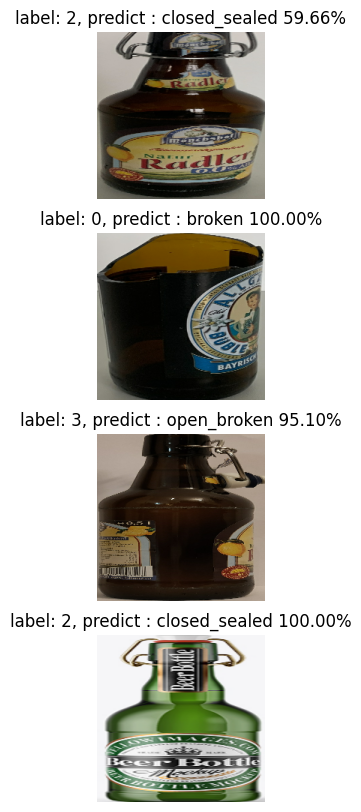

In [21]:
image ,label = next(iter(test_ds))

fig, axes = plt.subplots(4,1,figsize=(10,10))

for idx, axe in enumerate(axes.flatten()):

    axe.axis('off')

    pred = model.predict(image[idx][None,...])

    y_pred = np.argmax(pred)

    score = tf.nn.softmax(pred)

    axe.imshow(image[idx].numpy().astype("uint8"))

    axe.set_title(f'label: {y_pred}, predict : {names[y_pred]} {100 * np.max(score):.2f}%')